# Drift correction

...for GPS tracks collected on drifting sea ice.

### needed:
- a mobile GPS track with X and Y (long, lat) coordinate pairs which needs drift removed
- a reference GPS track which contains the drift to be removed (eg from a fixed-to-floe GPS)

### basic strategy:
1. collect a common time window between the reference and mobile GPS track
2. choose a projected coordinate system expressed in meters, and reproject both GPS tracks to it
3. if one track has a higher time resolution, interpolate the other track so that both tracks have the same time resolution
4. subtract the reference track positions from the mobile track positions

### caveat:

This strategy assumes the ice floe has not rotated significantly during the survey.

In [1]:
## import all the libraries

# standard stuff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

# reprojection help
import pyproj
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info

# xml help for GPX files
import xml.etree.ElementTree as et

# cartopy, basemap is deprecated

In [2]:
## functions we make ourselves go here

## these are from PhD work in 2015
def trim_timeseries(t1, t2):
#trim a long timeseries to match a shorter one.
#t1 is the long series, t2 is the short sries
#returns a set of indices to apply to the longer
#timeseries dataset
    start = np.min(t2)-5.
    end = np.max(t2)+5.
    idx = (t1>start)*(t1<end)
    the_inds = np.where(idx)
    return np.asarray(the_inds), start, end

## this was used for lidar work, but not here - instead we get an exact time match to an image trajectory
def find_nearest_vector(array, value):
#http://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
  idx = np.array([np.linalg.norm(x+y) for (x,y) in array-value]).argmin()
  return idx

# sometimes we can get lucky and get proj to find a UTM code for us
def getutm(lon,lat):
    utm_crs_list = query_utm_crs_info(
        datum_name="WGS 84",
        area_of_interest=AreaOfInterest(
            west_lon_degree=lon-0.1,
            south_lat_degree=lat-0.1,
            east_lon_degree=lon+0.1,
            north_lat_degree=lat+0.1,
            ),
        )
    print(utm_crs_list)
    return utm_crs_list[0].code

# convert from lat lon to UTM
def makeutm(lon,lat,utmcode):
    
    thetransform = pyproj.transformer.Transformer.from_proj(4326,utmcode)
    gnssutm=thetransform.transform(lat, lon)
    east = gnssutm[0]
    north = gnssutm[1]
    
    return east, north

def readbasegps(filename, skiptherows = 18):
    if 'gpx' in filename:
        # do xml parsing
        tree = et.parse(filename)
        print(filename)
        root = tree.getroot()
        trk = root.find('{http://www.topografix.com/GPX/1/1}trk')
        trksegs = trk.findall('{http://www.topografix.com/GPX/1/1}trkseg')
        trkpts = []
        for trkseg in trksegs:
            trkpts = trkpts + trkseg.findall('{http://www.topografix.com/GPX/1/1}trkpt')
        lon_pts = [float(trkpt.get('lon')) for trkpt in trkpts]
        lat_pts = [float(trkpt.get('lat')) for trkpt in trkpts]
        thetimes = [datetime.strptime(trkpt.find('{http://www.topografix.com/GPX/1/1}time').text,'%Y-%m-%dT%H:%M:%SZ')  for trkpt in trkpts]
        
        start_time = trkpts[0].find('{http://www.topografix.com/GPX/1/1}time')
        #start_time = datetime.strptime(start_time.text, '%Y-%m-%dT%H:%M:%SZ')
        
        stop_idx = max(np.nonzero(np.diff(lat_pts))[0][-1],np.nonzero(np.diff(lon_pts))[0][-1])
        
        lon_pts = lon_pts[:stop_idx]
        lat_pts = lat_pts[:stop_idx]
        times = thetimes[:stop_idx]
        
    else:
        # assume POS CVS file, read with Pandas
        gnsstrack = pd.read_csv(filename,
                       skiprows=skiptherows)
        
        print(gnsstrack.keys())

        thetimes = gnsstrack[gnsstrack.keys()[0]].values
        
        
        print(thetimes[0:4])
        
        lat_pts = gnsstrack[" latitude(deg)"].values
        lon_pts = gnsstrack["longitude(deg)"].values
        # remove any leading or trailing spaces from the time string using strip,
        # drop precision to milliseconds (6 decimal places) by removing the last 0
        # then convert it to a datetime object
        times = [datetime.strptime(thistime.strip()[0:-2], "%Y/%m/%d %H:%M:%S.%f") for thistime in thetimes]
    
    #return lists of lon, lat and time, we do reprojection in its own function later
    return lon_pts, lat_pts, times

In [3]:

def trim_timeseries(t1, t2):
#trim a long timeseries to match a shorter one.
#t1 is the long series, t2 is the short sries
#returns a set of indices to apply to the longer
#timeseries dataset
    start = t2[0]
    end = t2[-1]
    
    print(start)
    
    lowidx = np.where(t1 < start)
    highidx = np.where(t1 > end)
    
    print(lowidx[0][-1])
    print(highidx[0][0])
    
    the_inds = np.arange(lowidx[0][-1], highidx[0][0]+1,1)
    
    
    #idx = (t1>=start)*(t1=<end)
    
    #the_inds = np.where(idx)
    #if t1[the_inds[0]] > start:
    #    inds2 = np.where(t1)
        
        
    return np.asarray(the_inds), start, end

In [9]:
glon, glat,gtimes = readbasegps("/mnt/documents/JC2-2/P8-01092021/gnss/base3-near/nav/02092021-day2.pos",
                               skiptherows=13)

Index(['%  UTC                 ', ' latitude(deg)', 'longitude(deg)',
       ' height(m)', '  Q', ' ns', '  sdn(m)', '  sde(m)', '  sdu(m)',
       ' sdne(m)', ' sdeu(m)', ' sdun(m)', 'age(s)', ' ratio', '   vn(m/s)',
       '   ve(m/s)', '   vu(m/s)', '     sdvn', '    sdve', '    sdvu',
       '   sdvne', '   sdveu', '   sdvun'],
      dtype='object')
['2021/09/02 07:24:14.000' '2021/09/02 07:24:14.500'
 '2021/09/02 07:24:15.000' '2021/09/02 07:24:15.500']


In [10]:
glat[0:5]

array([83.83035353, 83.83035361, 83.83035356, 83.83035354, 83.83035365])

In [11]:
gtimes[-1]

datetime.datetime(2021, 9, 2, 17, 45, 7)

In [12]:
gnssdayseconds=[]
for thetime in gtimes:
    hour = datetime.strftime(thetime, "%H")
    minute = datetime.strftime(thetime, "%M")
    second = datetime.strftime(thetime, "%S")
    millisecond = float(datetime.strftime(thetime, "%f")) / 1000000
    gnssdayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + int(second) + float(millisecond))

Now we have an ice floe drift track loaded, either from a handheld GPS fixed to the ice (gpx files) or kPPP processed GPS base stations (pos files)

### Transform track data to UTM (or other projected system measured in meters)

In [13]:
## get the UTM zone
utmzone=getutm(glon[0], glat[0])
utmzone

[CRSInfo(auth_name='EPSG', code='32635', name='WGS 84 / UTM zone 35N', type=<PJType.PROJECTED_CRS: 'PROJECTED_CRS'>, deprecated=False, area_of_use=AreaOfUse(west=24.0, south=0.0, east=30.0, north=84.0, name='Between 24°E and 30°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Bulgaria. Central African Republic. Democratic Republic of the Congo (Zaire). Egypt. Estonia. Finland. Greece. Latvia. Lesotho. Libya. Lithuania. Moldova. Norway. Poland. Romania. Russian Federation. Sudan. Svalbard. Turkey. Uganda. Ukraine.'), projection_method_name='Transverse Mercator')]


'32635'

In [14]:
## set up the proj transformer

thetransform = pyproj.transformer.Transformer.from_proj(4326,3413)

In [15]:
gnssutm = thetransform.transform(glat, glon)
gnssutm = np.array(gnssutm)

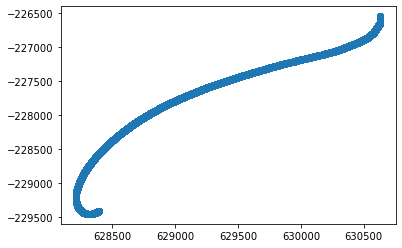

In [16]:
plt.scatter(gnssutm[0], gnssutm[1])

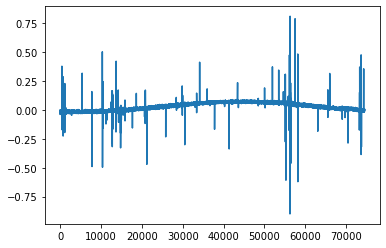

In [17]:
plt.plot(np.diff(gnssutm[0]))

In [18]:
gnssdayseconds[0:5]

[26654.0, 26654.5, 26655.0, 26655.5, 26656.0]

## Load  GEM2 data to be drift corrected

In [19]:
gem2inputfile = "/mnt/documents/JC2-2/P8-01092021/gem2/02092021/JC2-2-P8-transect-02092021-gem2-531-channel-thickness.csv"

In [20]:
gem2data = pd.read_csv(gem2inputfile, low_memory = False)

In [21]:
gem2data

time   record_id   longitude   latitude   xc   yc  \
0     2021-09-01T12:10:21.515625           0         0.0        0.0  0.0  0.0   
1     2021-09-01T12:10:21.617187           1         0.0        0.0  0.0  0.0   
2     2021-09-01T12:10:21.718750           2         0.0        0.0  0.0  0.0   
3     2021-09-01T12:10:21.820312           3         0.0        0.0  0.0  0.0   
4     2021-09-01T12:10:21.921875           4         0.0        0.0  0.0  0.0   
...                          ...         ...         ...        ...  ...  ...   
7933  2021-09-01T12:23:34.828125        7933         0.0        0.0  0.0  0.0   
7934  2021-09-01T12:23:34.929687        7934         0.0        0.0  0.0  0.0   
7935  2021-09-01T12:23:35.031250        7935         0.0        0.0  0.0  0.0   
7936  2021-09-01T12:23:35.132812        7936         0.0        0.0  0.0  0.0   
7937  2021-09-01T12:23:35.226562        7937         0.0        0.0  0.0  0.0   

       f450Hz_hcp_i   f450Hz_hcp_q   f1530Hz_hcp_i   f1530Hz_hcp_q  \
0             2.087          1.945           1.920           1.913   
1             2.236          1.892           1.921           1.919   
2             3.765          1.912           1.922           1.942   
3             2.859          1.992           2.099           1.950   
4             1.762          1.945           2.242           1.945   
...             ...            ...             ...             ...   
7933          0.080          0.684           0.715           0.627   
7934          0.386          0.707           0.708           0.615   
7935          0.558          0.745           0.838           0.614   
7936          0.888          0.739           0.834           0.622   
7937          1.130          0.676           0.727           0.623   

       f5310Hz_hcp_i   f5310Hz_hcp_q   f18330Hz_hcp_i   f18330Hz_hcp_q  \
0              1.981           1.931            1.939            1.916   
1              1.964           1.925            1.933            1.916   
2              1.968           1.918            1.939            1.917   
3              1.970           1.919            1.937            1.916   
4              1.961           1.917            1.938            1.916   
...              ...             ...              ...              ...   
7933           0.635           0.619            0.568            0.650   
7934           0.638           0.614            0.566            0.649   
7935           0.644           0.612            0.566            0.649   
7936           0.646           0.617            0.568            0.648   
7937           0.646           0.623            0.570            0.650   

       f63030Hz_hcp_i   f63030Hz_hcp_q  
0               1.921            1.895  
1               1.923            1.892  
2               1.924            1.893  
3               1.923            1.896  
4               1.925            1.897  
...               ...              ...  
7933            0.549            0.845  
7934            0.549            0.845  
7935            0.550            0.846  
7936            0.550            0.845  
7937            0.550            0.845  

[7938 rows x 16 columns]

In [22]:
gem2data.drop(gem2data[gem2data[" longitude"] == 0].index, inplace=True)
gem2data.drop(gem2data[gem2data[" latitude"] == 0].index, inplace=True)

In [23]:
gem2data

time   record_id   longitude   latitude   xc   yc  \
9     2021-09-01T12:10:22.421875           9   25.065791  83.831564  0.0  0.0   
10    2021-09-01T12:10:22.515625          10   25.065793  83.831564  0.0  0.0   
11    2021-09-01T12:10:22.617187          11   25.065794  83.831564  0.0  0.0   
12    2021-09-01T12:10:22.718750          12   25.065796  83.831564  0.0  0.0   
13    2021-09-01T12:10:22.820312          13   25.065797  83.831564  0.0  0.0   
...                          ...         ...         ...        ...  ...  ...   
7920  2021-09-01T12:23:33.531250        7920   25.077599  83.834177  0.0  0.0   
7921  2021-09-01T12:23:33.632812        7921   25.077600  83.834177  0.0  0.0   
7922  2021-09-01T12:23:33.726562        7922   25.077601  83.834177  0.0  0.0   
7923  2021-09-01T12:23:33.828125        7923   25.077603  83.834177  0.0  0.0   
7924  2021-09-01T12:23:33.929687        7924   25.077604  83.834177  0.0  0.0   

       f450Hz_hcp_i   f450Hz_hcp_q   f1530Hz_hcp_i   f1530Hz_hcp_q  \
9             1.801          1.946           1.867           1.970   
10            2.542          1.868           1.925           1.945   
11            1.479          1.862           1.873           1.955   
12            1.387          1.919           1.756           1.965   
13            1.749          2.004           1.897           1.925   
...             ...            ...             ...             ...   
7920          1.971          0.709           0.758           0.621   
7921          1.912          0.689           0.737           0.626   
7922          1.074          0.707           0.713           0.640   
7923          1.148          0.745           0.711           0.634   
7924          0.592          0.739           0.683           0.624   

       f5310Hz_hcp_i   f5310Hz_hcp_q   f18330Hz_hcp_i   f18330Hz_hcp_q  \
9              1.964           1.940            1.941            1.914   
10             1.960           1.935            1.943            1.915   
11             1.958           1.928            1.937            1.913   
12             1.964           1.917            1.938            1.917   
13             1.934           1.917            1.940            1.919   
...              ...             ...              ...              ...   
7920           0.643           0.618            0.566            0.651   
7921           0.642           0.619            0.564            0.650   
7922           0.632           0.620            0.567            0.648   
7923           0.631           0.618            0.570            0.649   
7924           0.663           0.621            0.569            0.651   

       f63030Hz_hcp_i   f63030Hz_hcp_q  
9               1.926            1.898  
10              1.921            1.900  
11              1.917            1.899  
12              1.922            1.896  
13              1.923            1.898  
...               ...              ...  
7920            0.550            0.847  
7921            0.549            0.847  
7922            0.549            0.846  
7923            0.550            0.846  
7924            0.550            0.845  

[7916 rows x 16 columns]

In [24]:
f1530hz_hcp_i = [float(zi) for zi in gem2data[" f1530Hz_hcp_i"].values]

In [25]:
gem2utm = thetransform.transform(gem2data[" latitude"].values, gem2data[" longitude"].values)

In [26]:
gem2easting = gem2utm[0]
gem2northing = gem2utm[1]

Text(0.5, 1.0, 'uncorrected GEM2track - local coordinates')

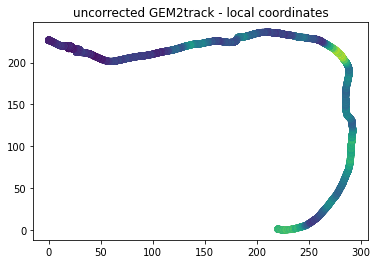

In [27]:
plt.scatter(gem2easting-np.min(gem2easting), gem2northing-min(gem2northing), c = f1530hz_hcp_i)
plt.title("uncorrected GEM2track - local coordinates")

In [29]:
gem2times = gem2data['time'].values
gem2dayseconds=[]
for thetime in gem2times:
    thisdate, thistime = thetime.split('T')
    #print(thistime)
    hour, minute, second = thistime.split(':')
    #print(len(thetime))
    #print(thetime)
    gem2dayseconds.append(((int(hour))*3600.0) + (int(minute) * 60.0) + float(second))

In [30]:
gem2dayseconds = np.round(gem2dayseconds, 4)

In [31]:
gem2times[-2]

'2021-09-01T12:23:33.828125'

In [32]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, gem2dayseconds)

43822.4219
34336
35920


In [33]:
gnss_trimmedtime = np.array(np.squeeze(gnss_trimmedtime))

In [34]:
gnss_trimmedtime

array([34336, 34337, 34338, ..., 35918, 35919, 35920])

In [35]:
start

43822.4219

In [36]:
end

44613.9297

In [37]:
gnssdayseconds = np.array(gnssdayseconds)

In [38]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [39]:
trimmedtime[0]

43822.0

In [40]:
gem2dayseconds[0]

43822.4219

In [41]:
timesteps = np.arange(trimmedtime.min()-0.5, trimmedtime.max()+0.5, 0.0001)
timesteps = np.round(timesteps, 4)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)
    

In [42]:
timesteps = np.round(timesteps, 4)

In [43]:
timesteps[0]

43821.5

In [44]:
gem2dayseconds[0]

43822.4219

In [45]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in gem2dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])
    else:
        print(thistimeindex[0])

CPU times: user 30.5 s, sys: 11.2 ms, total: 30.6 s
Wall time: 30.6 s


In [46]:
len(timeindexes)

7916

In [47]:
len(gem2dayseconds)

7916

In [48]:
gnss_gem2_match_eastings = interp_east[timeindexes]
gnss_gem2_match_northings = interp_north[timeindexes]

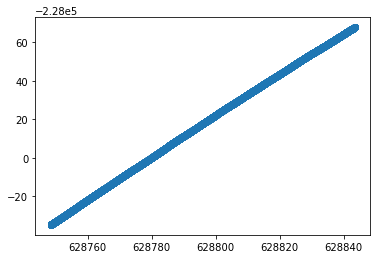

In [49]:
plt.scatter(gnss_gem2_match_eastings, gnss_gem2_match_northings)

In [50]:
gnss_gem2_match_eastings[0]

array([628748.35051281])

In [51]:
len(gnss_gem2_match_eastings)

7916

In [52]:
len(gem2easting)

7916

In [53]:
gnss_gem2_match_eastings = np.squeeze(gnss_gem2_match_eastings)
gnss_gem2_match_northings = np.squeeze(gnss_gem2_match_northings)

In [54]:
gnss_gem2_match_eastings[0]

628748.3505128087

In [55]:
gem2easting[0]

628757.0390371879

In [56]:
local_gem2_east = gem2easting - gnss_gem2_match_eastings
local_gem2_north = gem2northing - gnss_gem2_match_northings

In [57]:
local_gem2_east[0]

8.688524379278533

In [58]:
local_gem2_north[0]

3.2727842110034544

In [59]:
world_gem2_east = local_gem2_east + gnss_gem2_match_eastings[0]
world_gem2_north = local_gem2_north + gnss_gem2_match_northings[0]

In [60]:
world_gem2_east.size

7916

In [61]:
gnss_gem2_match_eastings[0]

628748.3505128087

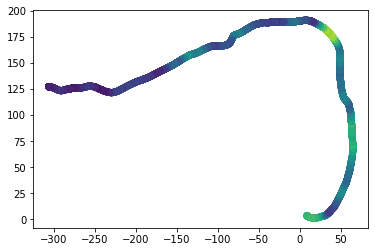

In [62]:
plt.scatter(local_gem2_east, local_gem2_north, c=f1530hz_hcp_i)

In [72]:
gem2_header = """AeN JC2-2 P8 GEM2 measurements
GEM2-531 electromagnetic induction sounder
2 September 2021
Adam Steer / Anca Cristea
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coodinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730
-----------------------------------------
"""

In [65]:
gem2_easting_df = pd.DataFrame({"easting": world_gem2_east})

In [66]:
gem2out = gem2data.copy()

In [67]:
gem2data.keys()

Index(['time', ' record_id', ' longitude', ' latitude', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

In [68]:
gem2out.drop(columns = [" longitude", " latitude"], inplace=True)
gem2out.keys()

Index(['time', ' record_id', ' xc', ' yc', ' f450Hz_hcp_i', ' f450Hz_hcp_q',
       ' f1530Hz_hcp_i', ' f1530Hz_hcp_q', ' f5310Hz_hcp_i', ' f5310Hz_hcp_q',
       ' f18330Hz_hcp_i', ' f18330Hz_hcp_q', ' f63030Hz_hcp_i',
       ' f63030Hz_hcp_q'],
      dtype='object')

In [69]:
gem2out.insert(2, "easting", world_gem2_east)

In [70]:
gem2out.insert(3, "northing", world_gem2_north)

In [71]:
gem2out.keys()

Index(['time', ' record_id', 'easting', 'northing', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

In [73]:
gem2_output = "/mnt/documents/JC2-2/P8-01092021/gem2/02092021/GEM2data-driftcorrected.csv"

In [74]:
with open(gem2_output, 'w') as outfile:
    outfile.write(gem2_header)
    

In [75]:
gem2out.to_csv(gem2_output, index=False, mode='a')

## Load Magnaprobe data to be drift corrected

Add 1024 weeks to NPI magnaprobe timestamps

In [103]:
magnaprobeinputfile = "/mnt/documents/JC2-2/P8-01092021/magnaprobe/03092021/NPI1.dat"


In [104]:
mpcolumns = ["TIMESTAMP","RECORD","Counter","DepthCm","BattVolts","latitude_a","latitude_b","Longitude_a","Longitude_b","fix_quality","nmbr_satellites","HDOP","altitudeB","DepthVolts","LatitudeDDDDD","LongitudeDDDDD","month","dayofmonth","hourofday","minutes","seconds","microseconds"]

In [105]:
mpdata = pd.read_csv(magnaprobeinputfile, skiprows=4, names = mpcolumns)

In [106]:
mpdepths = mpdata["DepthCm"].values / 100
mprawtimes = mpdata["TIMESTAMP"].values
mprawtimes = mprawtimes
mprawtimes[0].split(' ')
mprawdays = [thistime.split(' ')[0] for thistime in mprawtimes]
mptimes = [thistime.split(' ')[1] for thistime in mprawtimes]
mpdays = [datetime.strptime(thisday, "%Y-%m-%d") for thisday in mprawdays]
mptimes = np.array(mptimes)

In [107]:
weekdelta = timedelta(weeks=1024)

In [108]:
mpdaysfixed = [day + weekdelta for day in mpdays]

In [109]:
mprawtimes[100]

'2002-01-17 12:13:05.28'

In [110]:
datetime.strptime(mprawtimes[0], "%Y-%m-%d %H:%M:%S.%f") + timedelta(hours = 8)

datetime.datetime(2002, 1, 17, 20, 10, 54, 280000)

In [118]:
mpdaysfixed = [day + weekdelta for day in mpdays]

In [123]:
pickdays = []
for theday in mpdaysfixed:
    if theday.day == 2:
        pickdays.append(theday.day)
pickdays = np.array(pickdays)

In [124]:
thesedays = np.where(pickdays == 2)

In [127]:
mp_dayseconds=[]
for thetime in mptimes[thesedays]:
    hour, minute, second = thetime.split(':')
    #print(len(thetime))
    #print(thetime)
    mp_dayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + float(second))

In [134]:
mp_dayseconds = np.round(mp_dayseconds, 2)


In [129]:
gnssdayseconds

array([26654. , 26654.5, 26655. , ..., 63906. , 63906.5, 63907. ])

In [130]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, mp_dayseconds)

43854.28
34400
36705


In [131]:
gnssdayseconds = np.array(gnssdayseconds)

In [132]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [133]:
timesteps = np.arange(trimmedtime.min()-0.01, trimmedtime.max()+0.01, 0.01)
timesteps = np.round(timesteps, 2)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)

In [135]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in mp_dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])

CPU times: user 19.7 ms, sys: 0 ns, total: 19.7 ms
Wall time: 19.9 ms


In [136]:
len(timeindexes)

637

In [137]:
len(mp_dayseconds)

637

In [138]:
gnss_mp_match_eastings = np.squeeze(interp_east[timeindexes])
gnss_mp_match_northings = np.squeeze(interp_north[timeindexes])

Now get geo-data from the magnaprobe organised

In [139]:
mplatddd = mpdata["latitude_a"].values[thesedays] + (mpdata["latitude_b"].values[thesedays] / 60)
mplonddd = mpdata["Longitude_a"].values[thesedays] + (mpdata["Longitude_b"].values[thesedays] / 60)

In [140]:
mputm = thetransform.transform(mplatddd, mplonddd)

In [141]:
mpeasting = mputm[0]
mpnorthing = mputm[1]

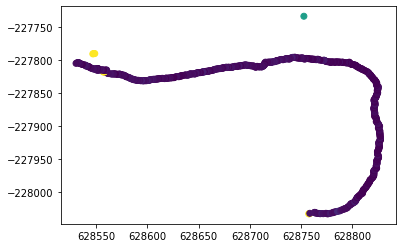

In [143]:
plt.scatter(mpeasting, mpnorthing, c = mpdata["DepthCm"].values[thesedays])

Do the drift correction to local coordinates

In [144]:
local_mp_east = mpeasting - gnss_mp_match_eastings
local_mp_north = mpnorthing - gnss_mp_match_northings

In [145]:
len(mpeasting)

637

In [146]:
len(gnss_mp_match_eastings)

637

Convert back to world coordinates

In [147]:
world_mp_east = local_mp_east + gnss_gem2_match_eastings[0]
world_mp_north = local_mp_north + gnss_gem2_match_northings[0]

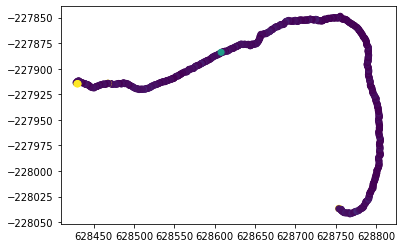

In [150]:
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"].values[thesedays])

Export data to CSV

In [151]:
# first generate correct timestamps! Remembering the raw times are 1024 weeks out
mp_timefixed = []
i = 0
for thistime in mptimes[thesedays]:
    theday = datetime.strftime(mpdaysfixed[i],"%d-%m-%Y")
    thetimestamp = theday + "T" + thistime
    mp_timefixed.append(thetimestamp)
    i += 1

In [152]:
mp_timefixed

['02-09-2021T12:10:54.28',
 '02-09-2021T12:10:55.19',
 '02-09-2021T12:10:56.85',
 '02-09-2021T12:11:02.12',
 '02-09-2021T12:11:16.01',
 '02-09-2021T12:11:17.66',
 '02-09-2021T12:11:19.28',
 '02-09-2021T12:11:20.61',
 '02-09-2021T12:11:21.8',
 '02-09-2021T12:11:23.05',
 '02-09-2021T12:11:24.28',
 '02-09-2021T12:11:25.51',
 '02-09-2021T12:11:26.66',
 '02-09-2021T12:11:27.83',
 '02-09-2021T12:11:28.93',
 '02-09-2021T12:11:30.09',
 '02-09-2021T12:11:31.27',
 '02-09-2021T12:11:32.39',
 '02-09-2021T12:11:33.55',
 '02-09-2021T12:11:34.72',
 '02-09-2021T12:11:35.93',
 '02-09-2021T12:11:37.19',
 '02-09-2021T12:11:38.31',
 '02-09-2021T12:11:39.5',
 '02-09-2021T12:11:40.66',
 '02-09-2021T12:11:41.82',
 '02-09-2021T12:11:43.06',
 '02-09-2021T12:11:44.53',
 '02-09-2021T12:11:45.92',
 '02-09-2021T12:11:47.19',
 '02-09-2021T12:11:48.28',
 '02-09-2021T12:11:49.43',
 '02-09-2021T12:11:50.63',
 '02-09-2021T12:11:51.76',
 '02-09-2021T12:11:52.86',
 '02-09-2021T12:11:54.02',
 '02-09-2021T12:11:55.12',
 '0

In [153]:
# Assemble a dataframe
mp_export = pd.DataFrame({"timestamp": mp_timefixed, 
                          "easting": world_mp_east, 
                          "northing": world_mp_north, 
                          "snowdepth": mpdata["DepthCm"].values[thesedays]/100   })

In [154]:
mp_output = "/mnt/documents/JC2-2/P8-01092021/magnaprobe/02092021/MPdata-driftcorrected-datefixed.csv"

In [155]:
mp_header = """AeN JC2-2 2021 P8 Magnaprobe measurements
Snowhydro Magnaprobe NPI-1
2 Seotember 2021
Adam Steer / Anca Cristea
Time corrected: add 1024 weeks to timestamps, accounting for 2019 GPS week rollover
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coordinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for date and drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730


"""

In [156]:
with open(mp_output, 'w') as outfile:
    outfile.write(mp_header)
    

In [157]:
mp_export.to_csv(mp_output, index=False, mode='a')

## Plot GEM2 and magnaprobe data together

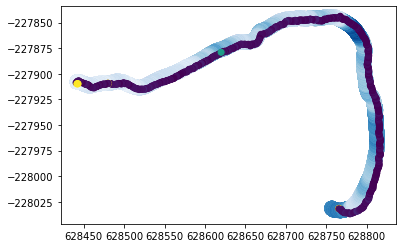

In [159]:
plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i, cmap = "Blues", s=200)
plt.scatter(world_mp_east+12, world_mp_north+5, c = mpdata["DepthCm"].values[thesedays]/100)

## Load camera centers to be drift corrected

In [196]:
cameracentrefile = "/mnt/documents/ANAFI-USA/jc2-2/02092021-jc2-2-p8/mapping-images/cameracenters.csv"

In [197]:
cameradata = pd.read_csv(cameracentrefile)

In [198]:
cameradata

SourceFile     DateTimeOriginal  SubSecTimeOriginal  GPSLatitude  \
0    ./jpg/P1053316.JPG  2021:09:02 10:25:05                 707    83.831121   
1    ./jpg/P1053317.JPG  2021:09:02 10:25:14                 398    83.831120   
2    ./jpg/P1053318.JPG  2021:09:02 10:25:25                 344    83.831119   
3    ./jpg/P1053319.JPG  2021:09:02 10:25:29                  11    83.831118   
4    ./jpg/P1053320.JPG  2021:09:02 10:25:32                 576    83.831119   
..                  ...                  ...                 ...          ...   
310  ./jpg/P1133670.JPG  2021:09:02 11:18:56                 452    83.832182   
311  ./jpg/P1133671.JPG  2021:09:02 11:18:59                 588    83.832101   
312  ./jpg/P1133672.JPG  2021:09:02 11:19:09                 116    83.831995   
313  ./jpg/P1133673.JPG  2021:09:02 11:19:13                 698    83.831990   
314  ./jpg/P1133674.JPG  2021:09:02 11:19:16                 748    83.831985   

     GPSLongitude  GPSAltitude  AboveGroundAltitude  GPSXYAccuracy  \
0       24.940209     6.979700             4.681967       1.702939   
1       24.940280    13.694619             8.825406       1.253994   
2       24.940331    27.359858            23.638393       0.757430   
3       24.940325    31.444649            29.004002       0.764199   
4       24.940332    36.716320            34.999512       0.926984   
..            ...          ...                  ...            ...   
310     24.945659    40.045197            44.059357       0.855862   
311     24.946411    41.140560            44.240578       0.912853   
312     24.954727    39.632195            44.052673       0.745185   
313     24.958784    39.481689            44.105541       0.787464   
314     24.959939    39.522125            44.051517       0.864523   

     GPSZAccuracy  CameraPitchDegree  CameraRollDegree  CameraYawDegree  
0             4.6         -78.074593          0.008437        16.941463  
1             3.3         -84.764633         -0.019152        16.691904  
2             2.0         -84.761688         -0.036499        16.793716  
3             2.0         -84.761459         -0.000608        16.758553  
4             2.3         -84.764900         -0.002191        16.839119  
..            ...                ...               ...              ...  
310           1.4         -55.502296         89.319176       -62.203312  
311           1.5         -33.992493         88.237465       -74.982086  
312           1.3         -39.484749         88.963509       -91.854851  
313           1.4         -40.805916         89.176842       -91.895889  
314           1.5        -124.005775        -89.689125        88.655365  

[315 rows x 12 columns]

In [199]:
cameradata.drop(cameradata[cameradata["GPSLongitude"] == 0].index, inplace=True)
cameradata.drop(cameradata[cameradata["GPSLatitude"] == 0].index, inplace=True)

In [200]:
camerautm = thetransform.transform(cameradata["GPSLatitude"].values, cameradata["GPSLongitude"].values)

In [201]:
cameraeasting = camerautm[0]
cameranorthing = camerautm[1]

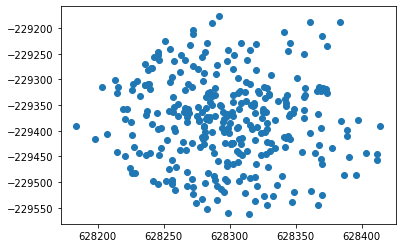

In [202]:
plt.scatter(cameraeasting, cameranorthing)

In [203]:
cameradata

SourceFile     DateTimeOriginal  SubSecTimeOriginal  GPSLatitude  \
0    ./jpg/P1053316.JPG  2021:09:02 10:25:05                 707    83.831121   
1    ./jpg/P1053317.JPG  2021:09:02 10:25:14                 398    83.831120   
2    ./jpg/P1053318.JPG  2021:09:02 10:25:25                 344    83.831119   
3    ./jpg/P1053319.JPG  2021:09:02 10:25:29                  11    83.831118   
4    ./jpg/P1053320.JPG  2021:09:02 10:25:32                 576    83.831119   
..                  ...                  ...                 ...          ...   
310  ./jpg/P1133670.JPG  2021:09:02 11:18:56                 452    83.832182   
311  ./jpg/P1133671.JPG  2021:09:02 11:18:59                 588    83.832101   
312  ./jpg/P1133672.JPG  2021:09:02 11:19:09                 116    83.831995   
313  ./jpg/P1133673.JPG  2021:09:02 11:19:13                 698    83.831990   
314  ./jpg/P1133674.JPG  2021:09:02 11:19:16                 748    83.831985   

     GPSLongitude  GPSAltitude  AboveGroundAltitude  GPSXYAccuracy  \
0       24.940209     6.979700             4.681967       1.702939   
1       24.940280    13.694619             8.825406       1.253994   
2       24.940331    27.359858            23.638393       0.757430   
3       24.940325    31.444649            29.004002       0.764199   
4       24.940332    36.716320            34.999512       0.926984   
..            ...          ...                  ...            ...   
310     24.945659    40.045197            44.059357       0.855862   
311     24.946411    41.140560            44.240578       0.912853   
312     24.954727    39.632195            44.052673       0.745185   
313     24.958784    39.481689            44.105541       0.787464   
314     24.959939    39.522125            44.051517       0.864523   

     GPSZAccuracy  CameraPitchDegree  CameraRollDegree  CameraYawDegree  
0             4.6         -78.074593          0.008437        16.941463  
1             3.3         -84.764633         -0.019152        16.691904  
2             2.0         -84.761688         -0.036499        16.793716  
3             2.0         -84.761459         -0.000608        16.758553  
4             2.3         -84.764900         -0.002191        16.839119  
..            ...                ...               ...              ...  
310           1.4         -55.502296         89.319176       -62.203312  
311           1.5         -33.992493         88.237465       -74.982086  
312           1.3         -39.484749         88.963509       -91.854851  
313           1.4         -40.805916         89.176842       -91.895889  
314           1.5        -124.005775        -89.689125        88.655365  

[315 rows x 12 columns]

In [204]:
cam_utm = thetransform.transform(cameradata["GPSLatitude"], cameradata["GPSLongitude"])

In [205]:
cam_rawtimes = cameradata["DateTimeOriginal"].values
cam_rawtimes = cam_rawtimes
cam_rawtimes[0].split(' ')
cam_rawdays = [thistime.split(' ')[0] for thistime in cam_rawtimes]
cam_times = [thistime.split(' ')[1] for thistime in cam_rawtimes]
cam_days = [datetime.strptime(thisday, "%Y:%m:%d") for thisday in cam_rawdays]
cam_times = np.array(cam_times)

In [206]:
subseconds = [x / 10**len(str(x)) for x in cameradata["SubSecTimeOriginal"]]
subseconds[0:5]

[0.707, 0.398, 0.344, 0.11, 0.576]

In [207]:
cam_dayseconds=[]
i = 0
for thetime in cam_times:
    hour, minute, second = thetime.split(':')
    #print(len(thetime))
    #print(thetime)
    cam_dayseconds.append((int(int(hour)-2)*3600.0) + (int(minute) * 60.0) + float(subseconds[i]))
    i += 1

In [208]:
cam_dayseconds[-1]

33540.748

In [209]:
gnssdayseconds[-1]

63907.0

In [210]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, cam_dayseconds)

30300.707
7293
13774


In [211]:
gnssdayseconds = np.array(gnssdayseconds)

In [212]:
len(cam_dayseconds)

315

In [213]:
gnss_trimmedtime

array([ 7293,  7294,  7295, ..., 13772, 13773, 13774])

In [214]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [215]:
len(trimmedeast)

6482

In [216]:
min(cam_dayseconds)

30300.11

In [217]:
max(cam_dayseconds)

33540.748

In [218]:
min(gnssdayseconds)

26654.0

In [219]:
max(gnssdayseconds)

63907.0

In [220]:
timesteps = np.arange(trimmedtime.min()-0.5, trimmedtime.max()+0.5, 0.001)
timesteps = np.round(timesteps, 3)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)

In [221]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in cam_dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])
    else:
        print(thistimeindex[0])

CPU times: user 471 ms, sys: 0 ns, total: 471 ms
Wall time: 470 ms


In [222]:
gnss_cam_match_eastings = np.squeeze(interp_east[timeindexes])
gnss_cam_match_northings = np.squeeze(interp_north[timeindexes])

In [223]:
local_cam_east = cameraeasting - gnss_cam_match_eastings
local_cam_north = cameranorthing - gnss_cam_match_northings

In [224]:
local_cam_east[0]

19.564932189998217

In [225]:
local_cam_north[0]

16.02458749440848

In [226]:
gnss_cam_match_northings[0] - gnss_cam_match_northings[-1]

-148.0294680648367

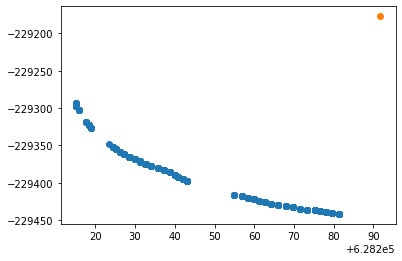

In [227]:
plt.scatter(gnss_cam_match_eastings, gnss_cam_match_northings)
plt.scatter(cameraeasting[-1], cameranorthing[-1])

In [228]:
cameraeasting[0]

628300.9069034057

In [229]:
gem2easting[0]

628757.0390371879

In [230]:
cameranorthing[0]

-229425.63252913245

In [231]:
gem2northing[0]

-228031.55755103636

In [232]:
local_gem2_east[0]

8.688524379278533

In [233]:
local_mp_east[0]

5.232733782264404

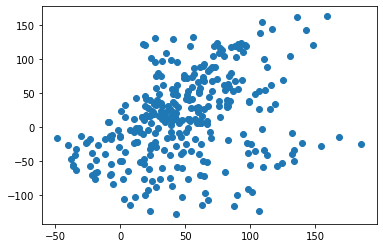

In [234]:
plt.scatter(local_cam_east, local_cam_north)

In [235]:
gnss_gem2_match_eastings[0]

628748.3505128087

In [ ]:
local_gem2_east[0]

In [236]:
world_cam_east = local_cam_east + gnss_gem2_match_eastings[0]
world_cam_north = local_cam_north + gnss_gem2_match_northings[0]

In [237]:
world_cam_east[0]

628767.9154449987

In [238]:
world_gem2_east[0]

628757.0390371879

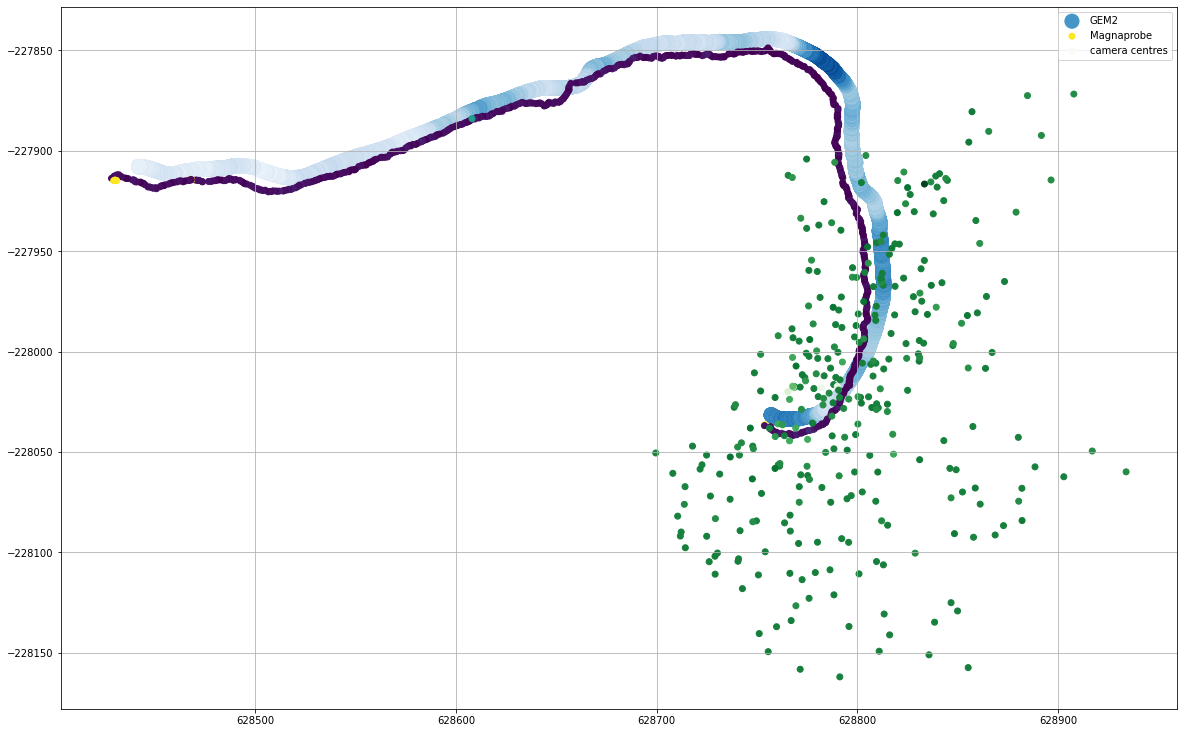

In [240]:
fig = plt.figure(figsize=(20,20))

#plt.scatter(gnssutm[0],gnssutm[1], s = 10, label = 'day 1 drift track')
#plt.scatter(gnss_cam_match_eastings, gnss_cam_match_northings, label = "camera match track")
#plt.scatter(gnss_mp_match_eastings, gnss_mp_match_northings)
#plt.scatter(gnss_gem2_match_eastings, gnss_gem2_match_northings)

plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i, cmap = "Blues", s=200, label = "GEM2")
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"].values[thesedays]/100, label = "Magnaprobe")
plt.scatter(world_cam_east, world_cam_north, c = cameradata["AboveGroundAltitude"], label = "camera centres", cmap="Greens")
plt.legend()
plt.grid()
ax = plt.gca()
ax.set_aspect("equal")
plt.savefig("/mnt/documents/Q2/AeNP6-09052021/driftracks.png")

In [241]:
backtolatlon = pyproj.transformer.Transformer.from_proj(3413,4326)

In [242]:
cam_latlon = backtolatlon.transform(world_cam_east, world_cam_north)

In [243]:
cam_out = cameradata.copy()

In [244]:
cam_out["GPSLatitude"] = cam_latlon[0]

In [245]:
cam_out["GPSLongitude"] = cam_latlon[1]

In [246]:
mp_output_exiftool = "/mnt/documents/ANAFI-USA/jc2-2/02092021-jc2-2-p8/driftcorrected-for-exiftool.csv"

In [247]:
cam_out.to_csv(mp_output_exiftool, index=False)

In [248]:
cam_out['GPSLatitude'][0] - cameradata["GPSLatitude"][0]

0.00038869556445320086

In [249]:
cam_out['GPSLatitude'][0]

83.83151019556445

cam_o

In [250]:
cam_out_hag = cam_out.copy()

In [251]:
cam_out_hag["GPSAltitude"] = cam_out_hag["AboveGroundAltitude"]

In [252]:
cam_out_hag.drop(columns = ["AboveGroundAltitude"], inplace = True)

In [253]:
cam_output_exiftool_hag = "/mnt/documents/ANAFI-USA/jc2-2/02092021-jc2-2-p8/driftcorrected-for-exiftool-HAG.csv"

In [254]:
cam_out_hag.to_csv(cam_output_exiftool_hag, index=False)